IMPORTING LIBRARIES

In [1]:
import pymannkendall as mk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
ds1 = xr.open_dataset('combined_temperature_data.nc')

In [6]:

ds_gh=ds1.sel(latitude=slice(11.5, 4.5), longitude=slice(-3.5, 1.5))
ds_gh

<xarray.Dataset> Size: 24MB
Dimensions:     (valid_time: 12544, latitude: 26, longitude: 18)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 100kB 1991-01-01 ... 2025-05-05
  * latitude    (latitude) float64 208B 10.96 10.71 10.46 ... 5.21 4.96 4.71
  * longitude   (longitude) float64 144B -3.24 -2.99 -2.74 ... 0.51 0.76 1.01
    number      int64 8B ...
    expver      (valid_time) <U4 201kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 23MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-10T22:27 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
ds_ghana_mean = ds_gh.mean(dim=['latitude', 'longitude'])



Changing Temperature from Kevin to Celsius

In [ ]:
temperature = ds_ghana_mean['t2m'].values - 273.15  
time = pd.to_datetime(ds_ghana_mean['valid_time'].values)


Ensuring all the years from 1991-2024 appears and interpolating missing Temperture values

In [ ]:

all_years = pd.DataFrame({'Year': np.arange(1991, 2024)})  # Inclusive of 2024
annual_data = all_years.merge(annual_data, on='Year', how='left')


annual_data['Temperature'] = annual_data['Temperature'].interpolate()


Converting the time series to a pandas Series


In [ ]:

df = pd.DataFrame({
    'Time': time,
    'Temperature': temperature
})
df

,Time,Temperature
0,1991-01-01,22.068481
1,1991-01-02,21.255463
2,1991-01-03,22.304047
3,1991-01-04,23.151794
4,1991-01-05,24.093140
...,...,...
12539,2025-05-01,26.865906
12540,2025-05-02,25.407745
12541,2025-05-03,26.214508
12542,2025-05-04,27.769073


In [33]:
df['Year'] = df['Time'].dt.year
annual_data = df.groupby('Year')['Temperature'].mean().reset_index()


Handling Missing Values

In [ ]:

print("Checking for missing values:")
print(annual_data.isnull().sum())
annual_data['Temperature'] = annual_data['Temperature'].interpolate()
annual_data = annual_data.sort_values('Year')


Checking for missing values:
Year            0
Temperature    11
dtype: int64


Plotting Annual Mean Temperature

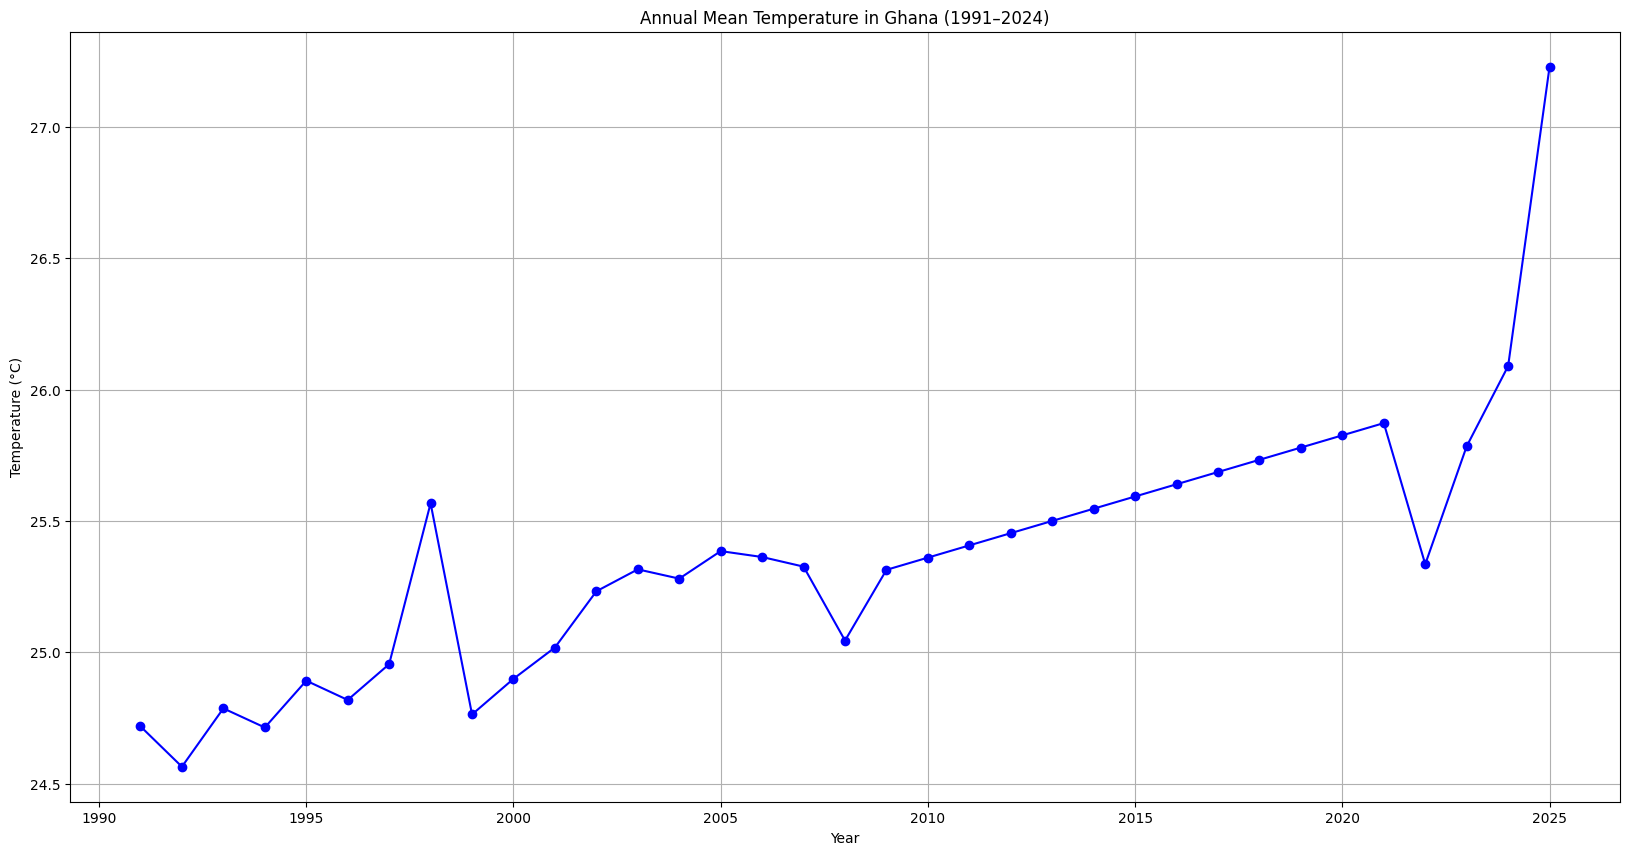

In [ ]:

plt.figure(figsize=(20, 10))
plt.plot(annual_data['Year'], annual_data['Temperature'], marker='o', linestyle='-', color='b')
plt.title('Annual Mean Temperature in Ghana (1991–2024)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


Computing the Mann-Kendall Trend Test

In [ ]:

temperature_series = annual_data['Temperature'].values
result = mk.original_test(temperature_series)


In [ ]:

print("\nMann-Kendall Test Results for Ghana:")
print(f"Trend: {result.trend}")
print(f"p-value: {result.p}")
print(f"Test Statistic (z): {result.z}")
print(f"Slope (Sen's slope): {result.slope:.4f} °C/year")
print(f"Intercept: {result.intercept:.4f}")




Mann-Kendall Test Results for Ghana:
Trend: increasing
p-value: 1.13473674900888e-11
Test Statistic (z): 6.7882845198687045
Slope (Sen's slope): 0.0413 °C/year
Intercept: 24.6583


In [ ]:

alpha = 0.05
if result.p < alpha:
    print(f"\nThe trend is statistically significant (p < {alpha}).")
    if result.trend == 'increasing':
        print("There is a significant increasing trend in temperature in Ghana.")
    elif result.trend == 'decreasing':
        print("There is a significant decreasing trend in temperature in Ghana.")
else:
    print(f"\nThe trend is not statistically significant (p >= {alpha}).")
    print("No clear trend in temperature in Ghana.")



The trend is statistically significant (p < 0.05).
There is a significant increasing trend in temperature in Ghana.


Plotting the Mann-Kendall Trend 

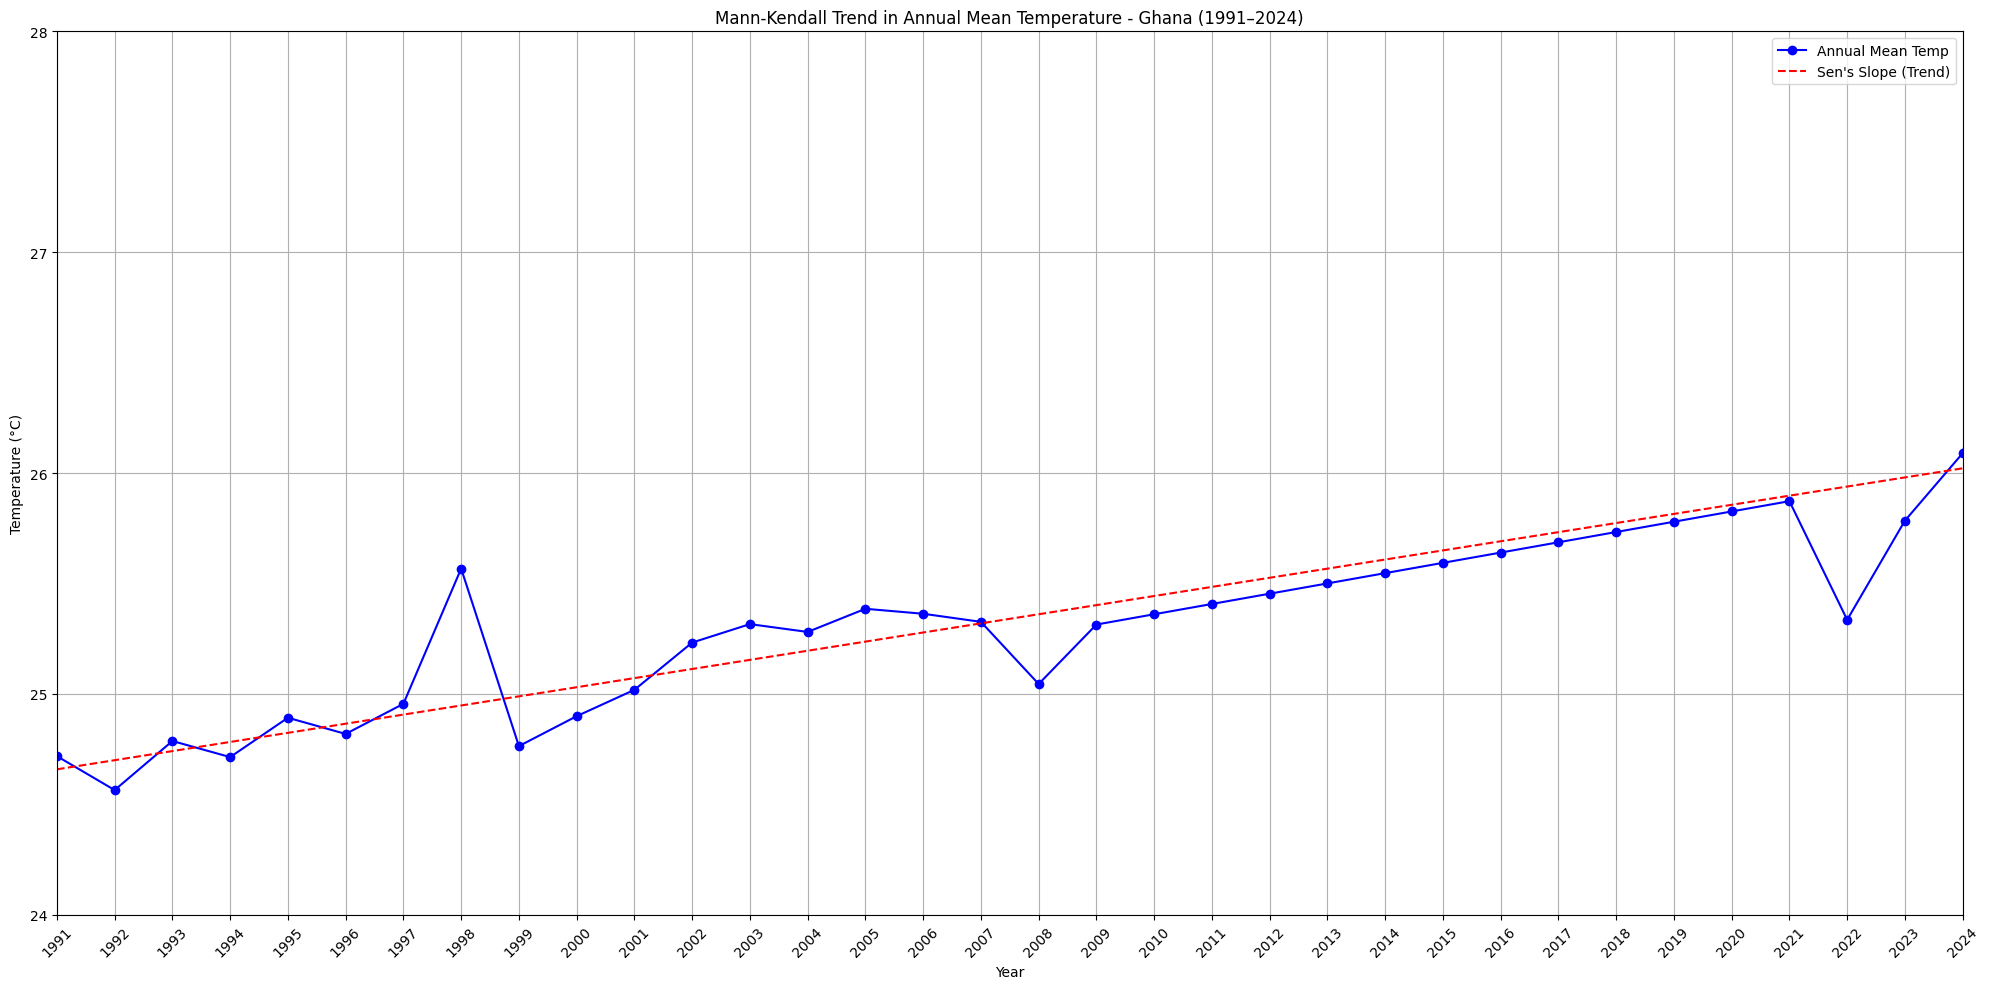

In [46]:
trend_line = result.slope * (annual_data['Year'] - annual_data['Year'].iloc[0]) + result.intercept

plt.figure(figsize=(20, 10))
plt.plot(annual_data['Year'], annual_data['Temperature'], marker='o', linestyle='-', color='b', label='Annual Mean Temp')
plt.plot(annual_data['Year'], trend_line, linestyle='--', color='r', label="Sen's Slope (Trend)")

# Set x-ticks and limits to ensure it ends at 2024
plt.xticks(np.arange(1991, 2025, 1), rotation=45)
plt.xlim(1991, 2024)

# Set y-ticks
y_min = np.floor(annual_data['Temperature'].min())
y_max = np.ceil(annual_data['Temperature'].max())
plt.yticks(np.arange(y_min, y_max + 1, 1))

plt.title("Mann-Kendall Trend in Annual Mean Temperature - Ghana (1991–2024)")
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
